In [1]:
import pandas
from tqdm import tqdm
import threading
import concurrent.futures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# import pprint
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import linear_model
# from sklearn.metrics import r2_score, mean_absolute_error
# import keras
# from keras import metrics
# from keras import regularizers
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout, Flatten, Activation
# from keras.optimizers import Adam, RMSprop
# from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
# from keras.utils import plot_model
# import seaborn as sns
# import h2o
# from h2o.automl import H2OAutoML

# h2o.init()

In [8]:
newDf.to_csv("~/Desktop/ML/rank_dataset.csv")

In [2]:
df = pandas.read_csv("~/Desktop/ML/dataset.csv")
df = df.drop(columns='Unnamed: 0')
df = df[df['markers']!=-1]
for column in df:
    if len(df[column].unique()) == 1:
        df.drop(columns=column, inplace=True)
# for column in ['mazeSearchOps', 'time']:
#     i = df.columns.get_loc(column)
#     df.iloc[:,i:i+1] = preprocessing.MinMaxScaler().fit_transform(df.iloc[:,i:i+1].to_numpy())

x_cols = []
for column in df:
    if column in ["score", "index", "time", "mazeSearchOps", "rank", "markers",'id']:
        continue
    x_cols.append(column)
label_columns = ['rank']


In [3]:

ids = df['id'].unique()
ids_train, ids_test = train_test_split(ids, test_size=0.2, random_state=42)
train = df[df['id'].isin(ids_train)]
test = df[df['id'].isin(ids_test)]

In [4]:
def getNewWorkerDf(workerDict, t, tLock):
    newWorkerDf = []
    sz = len(workerDict)
    added = 0
    for index1 in range(sz):
        for index2 in range(sz):
            if index1 == index2:
                continue
            item1 = workerDict[index1]
            item2 = workerDict[index2]
            newItem = item1.copy()
            newItem['workerDRCCost_1'] = newItem.pop('workerDRCCost')
            newItem['workerMarkerCost_1'] = newItem.pop('workerMarkerCost')
            newItem['mazeEndIter_1'] = newItem.pop('mazeEndIter')
            newItem['followGuide_1'] = newItem.pop('followGuide')
            newItem['workerDRCCost_2'] = item2['workerDRCCost']
            newItem['workerMarkerCost_2'] = item2['workerMarkerCost']
            newItem['mazeEndIter_2'] = item2['mazeEndIter']
            newItem['followGuide_2'] = item2['followGuide']
            newItem.pop('score')
            newItem.pop('rank')
            newItem.pop('mazeSearchOps')
            newItem.pop('time')
            newItem.pop('markers')
            if item1['markers'] < item2['markers']:
                newItem['score']  = 1.0
            elif item1['markers'] > item2['markers']:
                newItem['score']  = 0.0
            else:
                newItem['score']  = 0.5
            newWorkerDf.append(newItem)
            added+=1
            if added == 100:
                added = 0
                tLock.acquire()
                t.update(100)
                tLock.release()
    return pandas.DataFrame(data=newWorkerDf)

In [5]:
newDf = pandas.DataFrame()
df.reset_index()
sz = 0
for workerId in ids:
    workerDf = df[df['id'] == workerId]
    sz  += (len(workerDf) * (len(workerDf)-1))
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    tLock = threading.Lock()
    with tqdm(total =  sz) as t:
        for workerId in ids:
            workerDict = df[df['id'] == workerId].to_dict(orient='records')
            future = executor.submit(getNewWorkerDf, workerDict, t, tLock)
            newDf = pandas.concat([newDf, future.result()])

100%|████████████████████████████▉| 5868000/5870334 [00:40<00:00, 143745.73it/s]


In [6]:
print(len(newDf[newDf['score']==0.0]), len(newDf[newDf['score']==0.5]),len(newDf[newDf['score']==1.]))

2598991 672352 2598991


In [7]:
sns.displot(data=newDf['score'], kde=True)
# sns.displot(data=train['score'], kde=True)

NameError: name 'sns' is not defined

In [18]:
# Run AutoML for 20 base models

hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x_cols, y='score', training_frame=hf_train, validation_frame=hf_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:43:30.263: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,20.51728,0.4080098,20.52052,21.17715,20.208246,20.530329,20.150162
mean_residual_deviance,1071.8904,37.52546,1074.7484,1126.4308,1069.7407,1067.9193,1020.6125
mse,1071.8904,37.52546,1074.7484,1126.4308,1069.7407,1067.9193,1020.6125
null_deviance,16623798.0000000,450140.22,16721883.0000000,17033052.0000000,16889172.0000000,16601055.0000000,15873828.0000000
r2,0.8216488,0.0052832,0.8193204,0.8156081,0.821815,0.8215035,0.8299969
residual_deviance,2965448.2,162505.17,3020043.0,3137109.8,3009180.5,2962408.0,2698499.5
rmse,32.73573,0.5726377,32.783356,33.562344,32.70689,32.679035,31.947025
rmsle,nan,0.0,nan,nan,nan,nan,nan


In [7]:
preds = aml.predict(hf_test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [10]:
mean_absolute_error(hf_test['score'].as_data_frame()['score'], preds.as_data_frame()['predict'])

49.54492614216599

In [66]:
preds['predict'].as_data_frame()['predict']

0      -37.104539
1      -17.139030
2      -26.695149
3       73.132432
4       77.429566
          ...    
1245   -47.473064
1246   -34.372899
1247   -23.456470
1248   -92.745162
1249   -94.752447
Name: predict, Length: 1250, dtype: float64

In [8]:
def getAucScore(X_true):
    ids = X_true['id'].unique()
    scores = 0
    for identifier in ids:
        items = X_true[X_true['id'] == identifier]
        sz = len(items)
        d = 0
        score = 0
        for i in range(0, sz):
            for j in range(i+1,sz):
                d+=1
                if (items.iloc[i]['rank'] > items.iloc[j]['rank']) and (items.iloc[i]['predict'] > items.iloc[j]['predict']):
                    score += 1
                elif (items.iloc[i]['rank'] < items.iloc[j]['rank']) and (items.iloc[i]['predict'] < items.iloc[j]['predict']):
                    score +=1
        scores += (score/d)/len(ids)
        print(score/d)
    return scores
            
    

In [9]:
hf_test['predict'] = preds
getAucScore(hf_test.as_data_frame())

0.7816901408450704
0.8575268817204301
0.6888888888888889
0.7342676418938503
0.781522748375116
0.7035371376106815
0.8357816926511697
0.610238961861054
0.6469049829774064
0.8280916844349681
0.8535221968956909


0.7565429961958479

In [18]:
0.8390479009005201 + 0.8020272361497989 + 0.7640978025379139 + 0.7542979230845672 + 0.8847281015955715 + 0.7952521790839241 + 0.5376044568245125+ 0.805448996641263+ 0.6264915334704858

6.808996130288557

In [24]:
6.808996130288557 / len(ids_test)

0.7565551255876175

In [23]:
test

,pinCnt,termCnt,area,id,via_fixedDensity,via_routeDensity,via_frcShortConstraint,via_frcSpacingTablePrlConstraint,via_frcMinEnclosedAreaConstraint,met1_fixedDensity,...,met5_frcMinEnclosedAreaConstraint,mazeEndIter,workerDRCCost,workerMarkerCost,followGuide,markers,time,mazeSearchOps,score,rank
1760,4451,3058,20996010000,63511f88790cd23c2e03719f,0.141991,2.820772,0,0,0,18.107159,...,0,64,32.0,8.0,True,54,0.380006,0.777879,73.267327,1
1761,4451,3058,20996010000,63511f88790cd23c2e03719f,0.141991,2.820772,0,0,0,18.107159,...,0,16,16.0,8.0,False,55,0.139591,0.326711,72.772277,2
1762,4451,3058,20996010000,63511f88790cd23c2e03719f,0.141991,2.820772,0,0,0,18.107159,...,0,64,16.0,4.0,False,56,0.325405,0.722087,72.277228,3
1763,4451,3058,20996010000,63511f88790cd23c2e03719f,0.141991,2.820772,0,0,0,18.107159,...,0,32,16.0,8.0,False,61,0.322210,0.592958,69.801980,4
1764,4451,3058,20996010000,63511f88790cd23c2e03719f,0.141991,2.820772,0,0,0,18.107159,...,0,32,32.0,8.0,False,65,0.426583,0.698828,67.821782,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13744,1070,690,2332890000,6358cca1426fa8dadb033ab3,0.120559,3.907668,0,0,0,21.262108,...,0,64,2.0,16.0,True,661,0.291750,0.615220,-1736.111111,352
13745,1070,690,2332890000,6358cca1426fa8dadb033ab3,0.120559,3.907668,0,0,0,21.262108,...,0,64,2.0,32.0,True,741,0.559500,0.695369,-1958.333333,353
13746,1070,690,2332890000,6358cca1426fa8dadb033ab3,0.120559,3.907668,0,0,0,21.262108,...,0,32,2.0,32.0,True,935,0.154786,0.430757,-2497.222222,354
13747,1070,690,2332890000,6358cca1426fa8dadb033ab3,0.120559,3.907668,0,0,0,21.262108,...,0,32,2.0,64.0,False,1068,0.204629,0.481594,-2866.666667,355


In [19]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20221027_164330,32.749,1072.5,20.5226,nan,1072.5
StackedEnsemble_BestOfFamily_1_AutoML_3_20221027_164330,32.7631,1073.42,20.4107,nan,1073.42
GBM_4_AutoML_3_20221027_164330,33.2279,1104.09,21.3374,nan,1104.09
DRF_1_AutoML_3_20221027_164330,33.4634,1119.8,21.1459,nan,1119.8
GBM_3_AutoML_3_20221027_164330,33.7866,1141.54,22.2839,nan,1141.54
XGBoost_grid_1_AutoML_3_20221027_164330_model_2,33.8716,1147.28,21.3068,nan,1147.28
GBM_2_AutoML_3_20221027_164330,34.1248,1164.5,22.6834,nan,1164.5
XRT_1_AutoML_3_20221027_164330,34.3141,1177.45,21.877,nan,1177.45
XGBoost_grid_1_AutoML_3_20221027_164330_model_3,34.35,1179.93,22.7744,nan,1179.93
GBM_5_AutoML_3_20221027_164330,34.9848,1223.93,23.8451,nan,1223.93


In [18]:
h2o.automl.get_leaderboard(aml, extra_columns = "ALL")

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20221027_151029,33.1082,1096.15,20.4453,nan,1096.15,5701,0.055751,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20221027_151029,33.1408,1098.31,20.3716,nan,1098.31,2226,0.055791,StackedEnsemble
GBM_4_AutoML_1_20221027_151029,33.7618,1139.86,21.6013,nan,1139.86,1927,0.053867,GBM
DRF_1_AutoML_1_20221027_151029,33.7971,1142.24,21.1106,nan,1142.24,5524,0.035957,DRF
XGBoost_grid_1_AutoML_1_20221027_151029_model_2,34.2263,1171.44,21.2761,nan,1171.44,598,0.002193,XGBoost
GBM_3_AutoML_1_20221027_151029,34.3624,1180.77,22.5985,nan,1180.77,1613,0.067757,GBM
XRT_1_AutoML_1_20221027_151029,34.6188,1198.46,21.9765,nan,1198.46,5543,0.037579,DRF
XGBoost_grid_1_AutoML_1_20221027_151029_model_3,34.6488,1200.54,22.898,nan,1200.54,736,0.001544,XGBoost
GBM_2_AutoML_1_20221027_151029,34.8847,1216.94,23.303,nan,1216.94,1580,0.071219,GBM
XGBoost_grid_1_AutoML_1_20221027_151029_model_1,35.2939,1245.66,23.5922,nan,1245.66,508,0.001716,XGBoost


In [17]:
t_model = Sequential()
t_model.add(Dense(len(x_cols), activation="relu", input_shape=(len(x_cols),)))
t_model.add(Dense(200, activation="relu"))
t_model.add(Dense(50, activation="relu"))
t_model.add(Dense(len(label_columns)))
t_model.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=0.001),
    metrics=[metrics.mae])

epochs = 500
batch = 128
history = t_model.fit(
    train[x_cols].astype(float), train['score'].astype(float),
    batch_size=batch,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
score = t_model.evaluate(test[x_cols].astype(float), test['score'].astype(float), verbose=0)

Epoch 1/500
109/109 [==============================] - 1s 2ms/step - loss: 1943492431446016.0000 - mean_absolute_error: 13677484.0000
Epoch 2/500
109/109 [==============================] - 0s 2ms/step - loss: 14886301696.0000 - mean_absolute_error: 38578.8516
Epoch 3/500
109/109 [==============================] - 0s 2ms/step - loss: 803593.8750 - mean_absolute_error: 408.1903
Epoch 4/500
109/109 [==============================] - 0s 2ms/step - loss: 9339.9297 - mean_absolute_error: 87.8591
Epoch 5/500
109/109 [==============================] - 0s 2ms/step - loss: 9281.7754 - mean_absolute_error: 87.6982
Epoch 6/500
109/109 [==============================] - 0s 2ms/step - loss: 9288.5928 - mean_absolute_error: 87.7781
Epoch 7/500
109/109 [==============================] - 0s 2ms/step - loss: 9315.6992 - mean_absolute_error: 87.8405
Epoch 8/500
109/109 [==============================] - 0s 2ms/step - loss: 14568.1328 - mean_absolute_error: 95.2907
Epoch 9/500
109/109 [===================

109/109 [==============================] - 0s 2ms/step - loss: 1079686070272.0000 - mean_absolute_error: 400075.8125
Epoch 137/500
109/109 [==============================] - 0s 2ms/step - loss: 317250976.0000 - mean_absolute_error: 8438.0723
Epoch 138/500
109/109 [==============================] - 0s 2ms/step - loss: 159791296.0000 - mean_absolute_error: 4928.2842
Epoch 139/500
109/109 [==============================] - 0s 2ms/step - loss: 57777.7109 - mean_absolute_error: 137.1732
Epoch 140/500
109/109 [==============================] - 0s 2ms/step - loss: 1134833.6250 - mean_absolute_error: 544.0560
Epoch 141/500
109/109 [==============================] - 0s 2ms/step - loss: 83898480.0000 - mean_absolute_error: 4480.7690
Epoch 142/500
109/109 [==============================] - 0s 2ms/step - loss: 18064196.0000 - mean_absolute_error: 2040.4614
Epoch 143/500
109/109 [==============================] - 0s 2ms/step - loss: 323993960448.0000 - mean_absolute_error: 250198.5781
Epoch 144/500

Epoch 203/500
109/109 [==============================] - 0s 2ms/step - loss: 8974.0156 - mean_absolute_error: 78.4990
Epoch 204/500
109/109 [==============================] - 0s 3ms/step - loss: 6320.1191 - mean_absolute_error: 72.2832
Epoch 205/500
109/109 [==============================] - 0s 3ms/step - loss: 6219.3398 - mean_absolute_error: 71.7657
Epoch 206/500
109/109 [==============================] - 0s 2ms/step - loss: 6235.9058 - mean_absolute_error: 71.9281
Epoch 207/500
109/109 [==============================] - 0s 2ms/step - loss: 6308.4189 - mean_absolute_error: 72.2680
Epoch 208/500
109/109 [==============================] - 0s 2ms/step - loss: 6210.6279 - mean_absolute_error: 71.7697
Epoch 209/500
109/109 [==============================] - 0s 2ms/step - loss: 6238.0615 - mean_absolute_error: 71.9250
Epoch 210/500
109/109 [==============================] - 0s 2ms/step - loss: 6559.7524 - mean_absolute_error: 73.3093
Epoch 211/500
109/109 [==============================] -

109/109 [==============================] - 0s 4ms/step - loss: 6369.9150 - mean_absolute_error: 72.9674
Epoch 339/500
109/109 [==============================] - 0s 3ms/step - loss: 6390.6665 - mean_absolute_error: 72.9513
Epoch 340/500
109/109 [==============================] - 0s 3ms/step - loss: 6423.8218 - mean_absolute_error: 73.1514
Epoch 341/500
109/109 [==============================] - 0s 3ms/step - loss: 6425.2163 - mean_absolute_error: 73.1556
Epoch 342/500
109/109 [==============================] - 0s 3ms/step - loss: 6460.3311 - mean_absolute_error: 73.4357
Epoch 343/500
109/109 [==============================] - 0s 3ms/step - loss: 6363.1270 - mean_absolute_error: 72.8001
Epoch 344/500
109/109 [==============================] - 0s 2ms/step - loss: 6520.8706 - mean_absolute_error: 73.6161
Epoch 345/500
109/109 [==============================] - 0s 3ms/step - loss: 6572.5903 - mean_absolute_error: 73.7491
Epoch 346/500
109/109 [==============================] - 0s 3ms/step -

109/109 [==============================] - 0s 2ms/step - loss: 6264.2432 - mean_absolute_error: 72.2021
Epoch 475/500
109/109 [==============================] - 0s 3ms/step - loss: 6681.4194 - mean_absolute_error: 73.8386
Epoch 476/500
109/109 [==============================] - 0s 3ms/step - loss: 6258.6758 - mean_absolute_error: 72.1593
Epoch 477/500
109/109 [==============================] - 0s 3ms/step - loss: 6383.0249 - mean_absolute_error: 72.6577
Epoch 478/500
109/109 [==============================] - 0s 3ms/step - loss: 6290.4165 - mean_absolute_error: 72.3224
Epoch 479/500
109/109 [==============================] - 0s 4ms/step - loss: 7058.2891 - mean_absolute_error: 75.1660
Epoch 480/500
109/109 [==============================] - 0s 3ms/step - loss: 6465.9321 - mean_absolute_error: 73.0272
Epoch 481/500
109/109 [==============================] - 0s 4ms/step - loss: 6390.7891 - mean_absolute_error: 72.5713
Epoch 482/500
109/109 [==============================] - 0s 4ms/step -

In [13]:
plot_model(t_model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
t_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               17500     
                                                                 
 dense_9 (Dense)             (None, 100)               50100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 67,701
Trainable params: 67,701
Non-trainable params: 0
_________________________________________________________________


In [59]:
dicta = {}
for mazeEndIter in df['mazeEndIter'].unique():
    for workerDRCCost in df['workerDRCCost'].unique():
        for markerCost in df['workerMarkerCost'].unique():
            for followGuide in df['followGuide'].unique():
                dicta["{}_{}_{}_{}".format(mazeEndIter, workerDRCCost, markerCost, followGuide)] = len(dicta)
for index, item in df.iterrows():
    itemstr = "{}_{}_{}_{}".format(item['mazeEndIter'], item['workerDRCCost'], item['workerMarkerCost'], item['followGuide'])
    df.at[index,'index'] = dicta[itemstr]


In [45]:
df['index'] = 0

In [60]:
df

,level_0,pinCnt,termCnt,area,id,via_fixedDensity,via_routeDensity,via_frcShortConstraint,met1_fixedDensity,met1_routeDensity,...,mazeEndIter,workerDRCCost,workerMarkerCost,followGuide,markers,time,mazeSearchOps,score,rank,index
0,50,4337,3208,20996010000,63508a2d790cd23c2e037191,0.156458,2.543645,0,18.594103,18.340784,...,32,4.0,2.0,False,0,0.003719,0.016469,100.0,360,0
1,51,4337,3208,20996010000,63508a2d790cd23c2e037191,0.156458,2.543645,0,18.594103,18.340784,...,64,4.0,2.0,False,0,0.004710,0.016469,100.0,359,72
2,52,4337,3208,20996010000,63508a2d790cd23c2e037191,0.156458,2.543645,0,18.594103,18.340784,...,16,4.0,2.0,False,0,0.005383,0.016469,100.0,358,144
3,53,4337,3208,20996010000,63508a2d790cd23c2e037191,0.156458,2.543645,0,18.594103,18.340784,...,64,16.0,4.0,True,0,0.006020,0.028239,100.0,357,87
4,54,4337,3208,20996010000,63508a2d790cd23c2e037191,0.156458,2.543645,0,18.594103,18.340784,...,32,16.0,4.0,True,0,0.007331,0.028239,100.0,356,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17520,19033,1067,675,2332890000,635a62ad426fa8dadb033ac9,0.173604,4.106014,0,22.255732,18.306295,...,32,8.0,64.0,False,811,0.055849,0.349163,-100.0,47,44
17521,19034,1067,675,2332890000,635a62ad426fa8dadb033ac9,0.173604,4.106014,0,22.255732,18.306295,...,16,4.0,32.0,True,856,0.019549,0.162408,-100.0,46,151
17522,19035,1067,675,2332890000,635a62ad426fa8dadb033ac9,0.173604,4.106014,0,22.255732,18.306295,...,32,2.0,32.0,True,887,0.049757,0.283068,-100.0,45,67
17523,19036,1067,675,2332890000,635a62ad426fa8dadb033ac9,0.173604,4.106014,0,22.255732,18.306295,...,16,2.0,16.0,True,893,0.018168,0.116686,-100.0,44,215


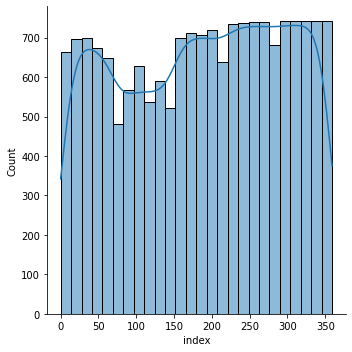

In [65]:
sns.displot(data=df['index'], kde=True)

Text(0, 0.5, 'mazeSearchOps')

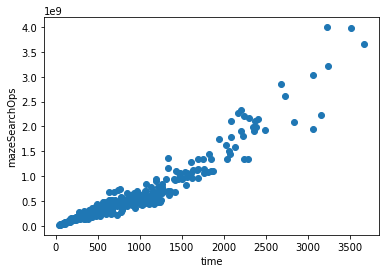

In [13]:
worker = df[df['id']=='63508a2d790cd23c2e037191']
plt.scatter(worker['time'], worker['mazeSearchOps'])
plt.xlabel('time')
plt.ylabel('mazeSearchOps')